# Interactive Tuning of Heuristic Score Weights

**Project:** Long-Tail Offline RL

**Objective:** To load the pre-computed raw heuristic score components and interactively visualize how different weight combinations affect the final criticality score. This notebook also generates a video of the corresponding scenario for direct visual verification, allowing for rapid, data-driven tuning of the heuristic weights.

In [1]:
# ## 1. Setup and Configuration
# 
# Load necessary libraries, add the project root to the Python path, and load the main configuration file.

# +
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import random
from ipywidgets import interact, FloatSlider, VBox, HBox, Output
from IPython.display import display, clear_output

# Add project root to path
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.utils.config import load_config
from src.data_processing.validate_parser_output import visualize_scenario

# Load project config and set plot style
config = load_config(config_path='../configs/main_config.yaml')
sns.set_theme(style="whitegrid")

print("Setup Complete.")

Configuration loaded successfully.
Setup Complete.


In [2]:
# ## 2. Load Scenario Data (Run this cell to load a new random scenario)
# 
# This cell performs the slow I/O. It loads the raw data and the score components for a single, randomly chosen scenario into global variables.

# +
# --- Global variables to hold the currently loaded data ---
CURRENT_SCENARIO_ID = None
CURRENT_SCORES_DATA = None
CURRENT_RAW_DATA_PATH = None

def load_new_random_scenario():
    """Loads a new scenario into the global variables."""
    global CURRENT_SCENARIO_ID, CURRENT_SCORES_DATA, CURRENT_RAW_DATA_PATH
    
    scores_dir = os.path.join(config['data']['criticality_scores_dir'], 'timestep_level', 'heuristic', 'validation')
    raw_data_dir = os.path.join(config['data']['processed_npz_dir'], 'validation')
    all_score_files = glob(os.path.join(scores_dir, '*.npz'))

    if not all_score_files:
        print("CRITICAL ERROR: No score files found.")
        return

    random_score_file_path = random.choice(all_score_files)
    
    base_filename = os.path.basename(random_score_file_path)
    CURRENT_SCENARIO_ID = base_filename.split('.')[0]
    
    CURRENT_RAW_DATA_PATH = os.path.join(raw_data_dir, f"{CURRENT_SCENARIO_ID}.npz")

    if not os.path.exists(CURRENT_RAW_DATA_PATH):
        print(f"ERROR: Raw data file for {CURRENT_SCENARIO_ID} not found. Trying another.")
        load_new_random_scenario() # Recursively try again
        return

    CURRENT_SCORES_DATA = np.load(random_score_file_path)
    print(f"--- Successfully Loaded Scenario: {CURRENT_SCENARIO_ID} ---")
    
# --- Initial Load ---
load_new_random_scenario()

--- Successfully Loaded Scenario: 59b4cd448af5c698 ---


In [3]:
# ## 3. Interactive Plotting Dashboard (Runs instantly)
# 
# This section defines the plotting function. It **does not load data from disk**; it uses the globally loaded data from the cell above. Adjusting the sliders will be instantaneous.

# +
def plot_weighted_scores(w_volatility, w_interaction, w_off_road, w_density, w_lane_deviation):
    """
    (Fast Version) Re-calculates and plots scores using pre-loaded data.
    """
    if CURRENT_SCORES_DATA is None:
        print("Please run the cell above to load a scenario first.")
        return

    # --- Use pre-loaded data ---
    volatility = CURRENT_SCORES_DATA['volatility']
    interaction = CURRENT_SCORES_DATA['interaction']
    off_road = CURRENT_SCORES_DATA['off_road']
    density = CURRENT_SCORES_DATA['density']
    lane_deviation = CURRENT_SCORES_DATA['lane_deviation']  # New score
    
    # --- Combine Scores (fast) ---
    final_scores = (w_volatility * volatility +
                    w_interaction * interaction +
                    w_off_road * off_road +
                    w_density * density +
                    w_lane_deviation * lane_deviation)  # New weight
    
    total_weight = w_volatility + w_interaction + w_off_road + w_density + w_lane_deviation
    # if total_weight > 0:
        # final_scores /= total_weight
    # final_scores = np.clip(final_scores, 0, 1) + 0.01

    # --- Plotting (fast) ---
    fig, axes = plt.subplots(2, 1, figsize=(18, 10), sharex=True, 
                             gridspec_kw={'height_ratios': [1, 2]})
    fig.suptitle(f'Interactive Weight Tuning for Scenario:', fontsize=16)

    timesteps = np.arange(len(final_scores))
    axes[0].plot(timesteps, final_scores, color='black', linewidth=2, label='Final Combined Score')
    axes[0].set_ylabel('Final Score')
    axes[0].set_ylim(0, 1.1)
    
    most_critical_timestep = np.argmax(final_scores)
    peak_score = np.max(final_scores)
    axes[0].axvline(x=most_critical_timestep, color='r', linestyle='--', label=f'Peak Score Timestep: {most_critical_timestep}')
    axes[0].annotate(f'Peak Score: {peak_score:.2f}', xy=(most_critical_timestep, peak_score), 
                     xytext=(most_critical_timestep + 2, peak_score + 0.1),
                     arrowprops=dict(facecolor='red', shrink=0.05, alpha=0.7),
                     fontsize=12, color='red')
    axes[0].legend()
    axes[0].grid(True)
    
    axes[1].plot(timesteps, volatility, label=f'Volatility (w={w_volatility:.2f})', alpha=0.7)
    axes[1].plot(timesteps, interaction, label=f'Interaction (w={w_interaction:.2f})', alpha=0.7)
    axes[1].plot(timesteps, off_road, label=f'Off-Road (w={w_off_road:.2f})', alpha=0.7)
    axes[1].plot(timesteps, density, label=f'Density (w={w_density:.2f})', alpha=0.7)
    axes[1].plot(timesteps, lane_deviation, label=f'Lane Deviation (w={w_lane_deviation:.2f})', alpha=0.7)
    axes[1].set_xlabel('Timestep')
    axes[1].set_ylabel('Raw Score Components')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [6]:
interact(
    plot_weighted_scores,
    w_volatility=FloatSlider(min=0.0, max=1.0, step=0.05, value=0.4, description='Volatility'),
    w_interaction=FloatSlider(min=0.0, max=1.0, step=0.05, value=0.05, description='Interaction'),
    w_off_road=FloatSlider(min=0.0, max=1.0, step=0.05, value=0.05, description='Off-Road'),
    w_density=FloatSlider(min=0.0, max=1.0, step=0.05, value=0.03, description='Density'),
    w_lane_deviation=FloatSlider(min=0.0, max=1.0, step=0.05, value=0.47, description='Lane Deviation')
)

interactive(children=(FloatSlider(value=0.4, description='Volatility', max=1.0, step=0.05), FloatSlider(value=…

<function __main__.plot_weighted_scores(w_volatility, w_interaction, w_off_road, w_density, w_lane_deviation)>

In [5]:
# ## 5. Generate Video for the Current Scenario (Optional)
# 
# After you have found interesting weights for the scenario loaded above, you can run this cell to generate the video for visual confirmation.

def generate_video_for_current_scenario():
    if CURRENT_RAW_DATA_PATH is None:
        print("No scenario loaded. Please run Cell #2 first.")
        return
        
    print(f"\nGenerating scenario animation for: {CURRENT_SCENARIO_ID}...")
    try:
        video_output_dir = 'outputs/heuristic_tuning_videos'
        visualize_scenario(CURRENT_RAW_DATA_PATH, output_dir=video_output_dir)
        print(f"\n✅ Animation saved to '{video_output_dir}/{CURRENT_SCENARIO_ID}.mp4'")
    except Exception as e:
        print(f"\n❌ An error occurred during animation: {e}")

generate_video_for_current_scenario()


Generating scenario animation for: 59b4cd448af5c698...
Loading scenario from: /mnt/d/waymo_datasets/waymo_longtail_rl_data/processed_npz/validation/59b4cd448af5c698.npz
Creating animation for timestep 0 to 90...
Animation saved to: outputs/heuristic_tuning_videos/59b4cd448af5c698.mp4

✅ Animation saved to 'outputs/heuristic_tuning_videos/59b4cd448af5c698.mp4'


--- Starting Global Score Analysis ---
Analyzing 8856 score files in parallel...


100%|██████████| 8856/8856 [00:03<00:00, 2351.12it/s]



--- Global Statistics for Raw Score Components ---

--- VOLATILITY ---
  Min: 0.0000 | Max: 1.0000 | Mean: 0.2805 | Std: 0.3036
  1st Percentile: 0.0000
  5th Percentile: 0.0062
  25th Percentile: 0.0363
  50th Percentile (Median): 0.1661
  75th Percentile: 0.4204
  95th Percentile: 1.0000
  99th Percentile: 1.0000

--- INTERACTION ---
  Min: 0.0000 | Max: 1.0000 | Mean: 0.5519 | Std: 0.3214
  1st Percentile: 0.0000
  5th Percentile: 0.0523
  25th Percentile: 0.2773
  50th Percentile (Median): 0.5410
  75th Percentile: 0.8520
  95th Percentile: 1.0000
  99th Percentile: 1.0000

--- OFF_ROAD ---
  Min: 0.0000 | Max: 0.9714 | Mean: 0.0003 | Std: 0.0141
  1st Percentile: 0.0000
  5th Percentile: 0.0000
  25th Percentile: 0.0000
  50th Percentile (Median): 0.0000
  75th Percentile: 0.0000
  95th Percentile: 0.0000
  99th Percentile: 0.0000

--- DENSITY ---
  Min: 0.0200 | Max: 1.0000 | Mean: 0.6141 | Std: 0.3000
  1st Percentile: 0.0600
  5th Percentile: 0.1400
  25th Percentile: 0.3600
 

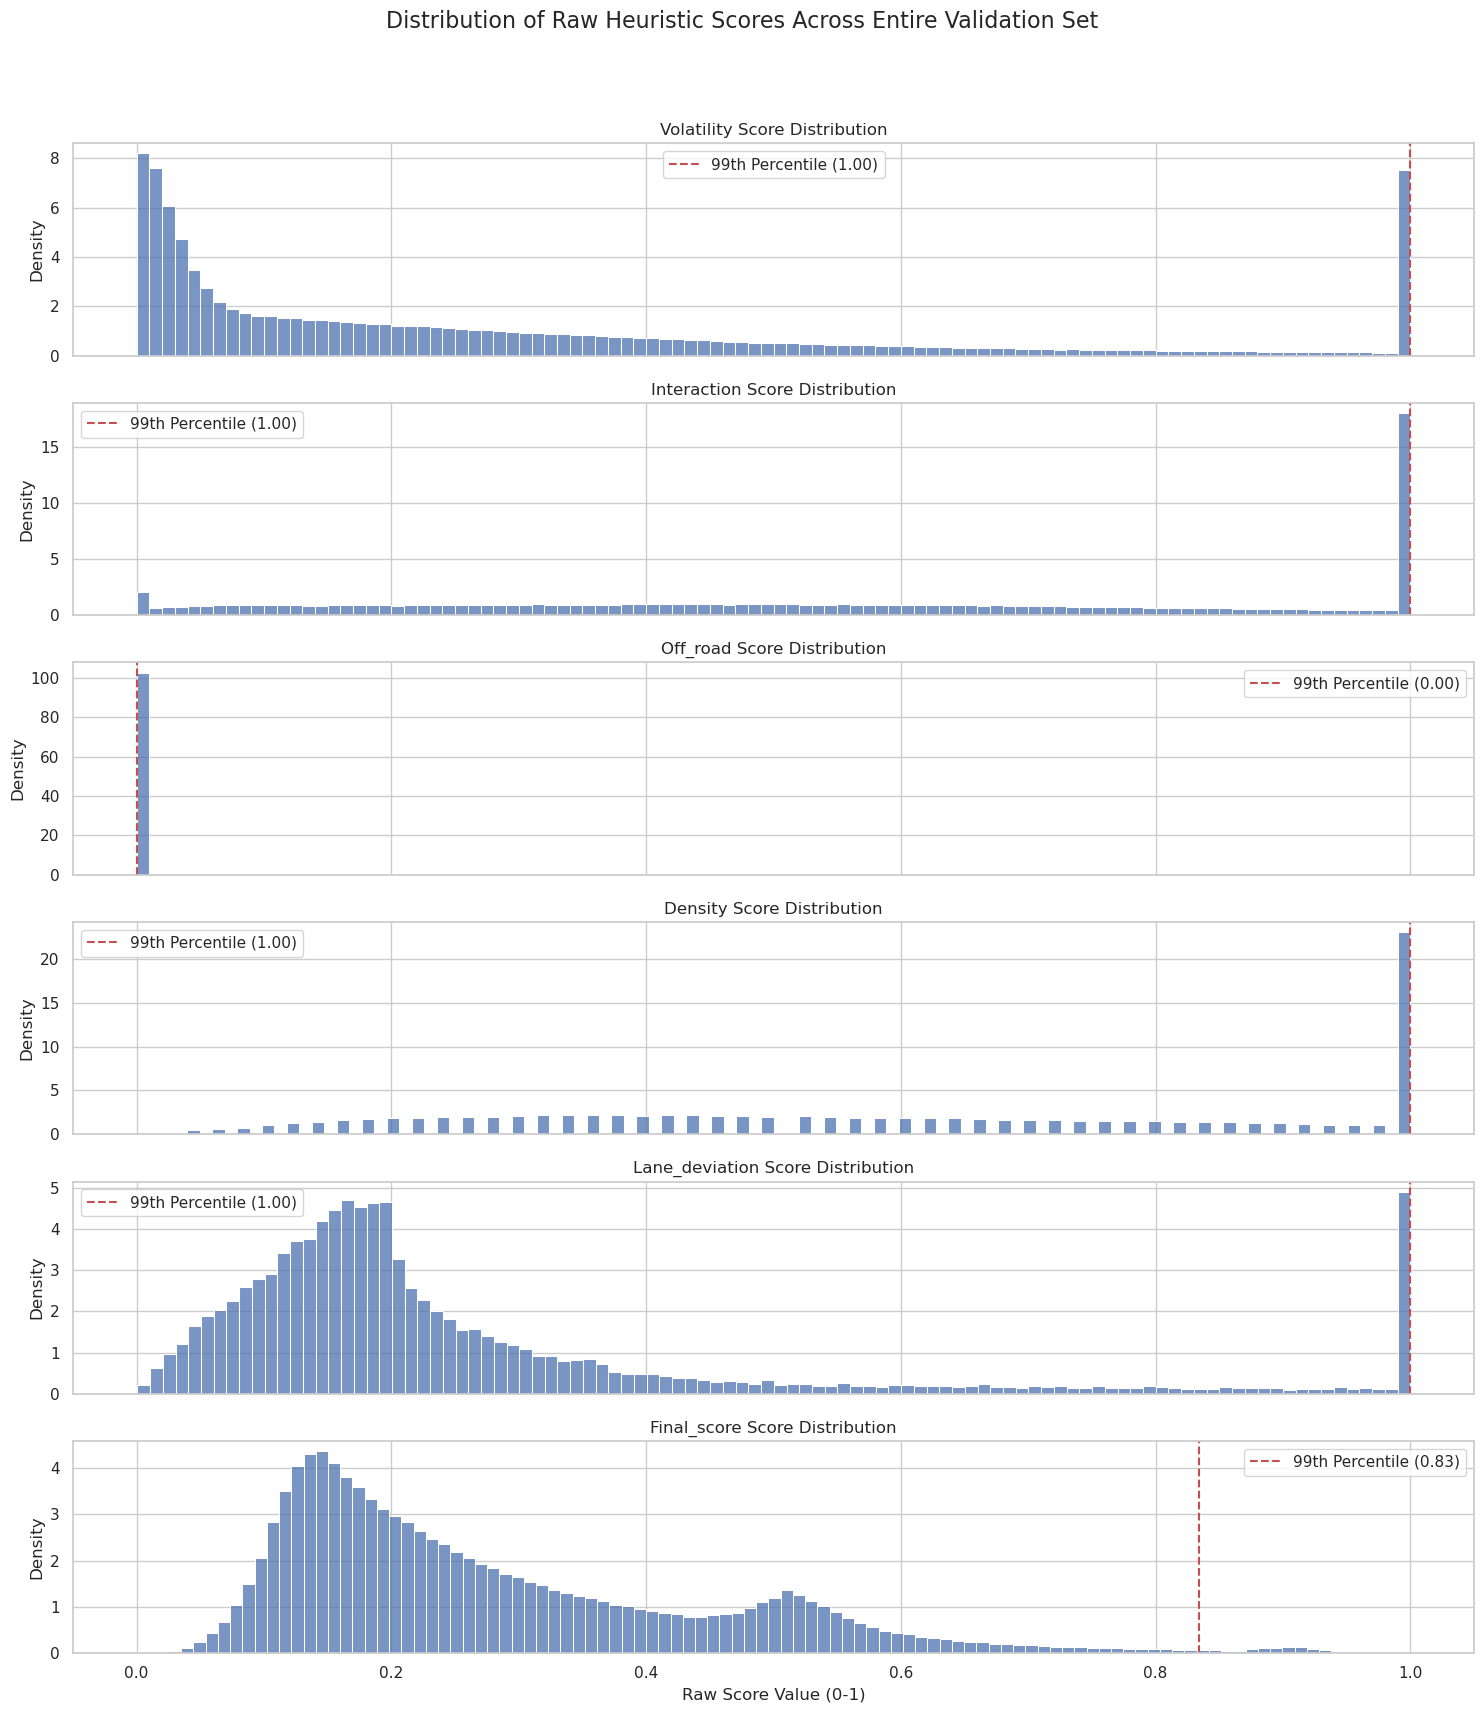

In [9]:
# ## 6. Global Score Distribution Analysis
# 
# This cell processes the ENTIRE validation set to find the true min, max, mean,
# and key percentiles for each raw heuristic score. This is crucial for
# understanding the actual dynamic range of each signal and for making
# informed decisions about normalization.

import multiprocessing
from functools import partial
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- Worker function for parallel processing ---
def analyze_score_file(file_path):
    """Loads a single score file and returns its raw score data."""
    try:
        data = np.load(file_path)
        # Return a dictionary of the arrays
        return {key: data[key] for key in data.keys()}
    except Exception:
        return None

# --- Main analysis logic ---
print("--- Starting Global Score Analysis ---")
scores_dir = os.path.join(config['data']['criticality_scores_dir'], 'timestep_level', 'heuristic', 'validation')
all_score_files = glob(os.path.join(scores_dir, '*.npz'))

if not all_score_files:
    print("No score files found to analyze.")
else:
    print(f"Analyzing {len(all_score_files)} score files in parallel...")
    
    # Use a multiprocessing pool to load all files quickly
    with multiprocessing.Pool() as pool:
        results = list(tqdm(pool.imap(analyze_score_file, all_score_files), total=len(all_score_files)))
    
    # Filter out any failed loads
    results = [res for res in results if res is not None]
    
    # --- Concatenate all scores into large arrays ---
    all_scores = {
        'volatility': np.concatenate([res['volatility'] for res in results]),
        'interaction': np.concatenate([res['interaction'] for res in results]),
        'off_road': np.concatenate([res['off_road'] for res in results]),
        'density': np.concatenate([res['density'] for res in results]),
        'lane_deviation': np.concatenate([res['lane_deviation'] for res in results])
    }
    
    weights = config['scoring']['heuristic']
    final_scores = (weights['weight_volatility'] * all_scores['volatility'] +
                    weights['weight_interaction'] * all_scores['interaction'] +
                    weights['weight_off_road'] * all_scores['off_road'] +
                    weights['weight_lane_deviation'] * all_scores['lane_deviation'] +
                    weights['weight_density'] * all_scores['density'])
    
    # Add the final score to our dictionary for plotting
    all_scores['final_score'] = final_scores
    
    print("\n--- Global Statistics for Raw Score Components ---")
    
    # --- Plotting and Metrics ---
    fig, axes = plt.subplots(len(all_scores), 1, figsize=(15, 18), sharex=True)
    fig.suptitle('Distribution of Raw Heuristic Scores Across Entire Validation Set', fontsize=16)
    
    for i, (name, scores) in enumerate(all_scores.items()):
        # Calculate statistics
        mean_val = np.mean(scores)
        std_val = np.std(scores)
        min_val = np.min(scores)
        max_val = np.max(scores)
        p1 = np.percentile(scores, 1)
        p5 = np.percentile(scores, 5)
        p25 = np.percentile(scores, 25)
        p50 = np.percentile(scores, 50)
        p75 = np.percentile(scores, 75)
        p95 = np.percentile(scores, 95)
        p99 = np.percentile(scores, 99)
        
        print(f"\n--- {name.upper()} ---")
        print(f"  Min: {min_val:.4f} | Max: {max_val:.4f} | Mean: {mean_val:.4f} | Std: {std_val:.4f}")
        print(f"  1st Percentile: {p1:.4f}")
        print(f"  5th Percentile: {p5:.4f}")
        print(f"  25th Percentile: {p25:.4f}")
        print(f"  50th Percentile (Median): {p50:.4f}")
        print(f"  75th Percentile: {p75:.4f}")
        print(f"  95th Percentile: {p95:.4f}")
        print(f"  99th Percentile: {p99:.4f}")
        
        # Plot distribution (histogram)
        sns.histplot(scores, bins=100, ax=axes[i], kde=False, stat='density')
        axes[i].set_title(f'{name.capitalize()} Score Distribution')
        axes[i].axvline(p99, color='r', linestyle='--', label=f'99th Percentile ({p99:.2f})')
        axes[i].legend()

    plt.xlabel('Raw Score Value (0-1)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
# -